In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.losses import Huber
import tensorflow as tf

# Function to load and preprocess images from a folder
def load_images(folder, start_index, num_images, img_size=(128, 128)):
    images = []
    files = sorted(os.listdir(folder))[start_index:start_index + num_images]
    for filename in files:
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, img_size)
            images.append(image)
    return np.array(images)

# Define paths to the image folders
front_dir = "A:/PRML_project/front/front"       #location front images
side_dir = "A:/PRML_project/side/side"      #location of side images

# Load the first 7916 images for training and the next 1891 for testing
X_front_train = load_images(front_dir, 0, 15000, (128, 128))
X_front_test = load_images(front_dir, 15000, 2000, (128, 128))

X_side_train = load_images(side_dir, 0, 15000, (128, 128))
X_side_test = load_images(side_dir, 15000, 2000, (128, 128))

# Normalize the images (scaling pixel values to [0, 1])
X_front_train = X_front_train / 255.0
X_front_test = X_front_test / 255.0
X_side_train = X_side_train / 255.0
X_side_test = X_side_test / 255.0

# Print the shape of the loaded data
print(f"X_front_train shape: {X_front_train.shape}")
print(f"X_side_train shape: {X_side_train.shape}")
print(f"X_front_test shape: {X_front_test.shape}")
print(f"X_side_test shape: {X_side_test.shape}")

# Load the CSV file containing labels (BMI and Gender)
labels_file = "A:/PRML_project/person.csv"
labels_df = pd.read_csv(labels_file, delimiter=';')

# Calculate BMI using height in inches and weight in pounds
labels_df['height_m'] = labels_df['height'] * 0.0254  # Convert height to meters
labels_df['weight_kg'] = labels_df['weight'] * 0.453592  # Convert weight to kilograms
labels_df['BMI'] = labels_df['weight_kg'] / (labels_df['height_m'] ** 2)

# Drop rows with invalid BMI values
labels_df = labels_df.dropna(subset=['BMI'])

# Extract BMI and Gender (sex)
bmi_labels = labels_df['BMI'].values[:17000]  # Ensure consistent number of labels
gender_labels = labels_df['sex'].values[:17000]

# Normalize BMI values to the range [0, 1]
bmi_min = np.min(bmi_labels)
bmi_max = np.max(bmi_labels)
bmi_labels = (bmi_labels - bmi_min) / (bmi_max - bmi_min)

# Slice the labels to match the number of images
bmi_train = bmi_labels[:15000]
bmi_test = bmi_labels[15000:15000 + 2000]

# Encode Gender Labels ('Male' -> 0, 'Female' -> 1)
encoder = LabelEncoder()
gender_labels_encoded = encoder.fit_transform(gender_labels)

# Slice the labels to match the number of images
gender_train_encoded = gender_labels_encoded[:15000]
gender_test_encoded = gender_labels_encoded[15000:15000 + 2000]

# One-hot encode the gender labels
gender_train_one_hot = to_categorical(gender_train_encoded)
gender_test_one_hot = to_categorical(gender_test_encoded)

# Debug: Ensure correct number of labels for training
print("gender_train_one_hot shape:", gender_train_one_hot.shape)
print("bmi_train shape:", bmi_train.shape)

# Define CNN Model for both front and side images using Functional API
def build_multi_input_cnn(input_shape=(128, 128, 3)):
    # Input for front images
    front_input = Input(shape=input_shape, name='front_input')
    x1 = Conv2D(32, (3, 3), activation='relu')(front_input)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Conv2D(128, (3, 3), activation='relu')(x1)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    x1 = Flatten()(x1)

    # Input for side images
    side_input = Input(shape=input_shape, name='side_input')
    x2 = Conv2D(32, (3, 3), activation='relu')(side_input)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Conv2D(128, (3, 3), activation='relu')(x2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Flatten()(x2)

    # Combine features from both inputs
    combined = Concatenate()([x1, x2])

    # Fully connected layers for gender classification
    gender_output = Dense(128, activation='relu')(combined)
    gender_output = Dropout(0.5)(gender_output)
    gender_output = Dense(64, activation='relu')(gender_output)
    gender_output = Dropout(0.5)(gender_output)
    gender_output = Dense(2, activation='softmax', name="gender_output")(gender_output)

    # Fully connected layer for BMI regression
    bmi_output = Dense(128, activation='relu')(combined)
    bmi_output = Dropout(0.5)(bmi_output)
    bmi_output = Dense(1, name="bmi_output")(bmi_output)

    # Create the model
    model = Model(inputs=[front_input, side_input], outputs=[gender_output, bmi_output])

    return model

# Build the model
model = build_multi_input_cnn()

# Compile the model using Huber Loss for BMI regression
model.compile(optimizer='adam',
              loss={'gender_output': 'categorical_crossentropy', 'bmi_output': Huber()},
              metrics={'gender_output': 'accuracy', 'bmi_output': 'mse'})

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    [X_front_train, X_side_train],
    {'gender_output': gender_train_one_hot, 'bmi_output': bmi_train},
    validation_split=0.2,
    epochs=10,
    batch_size=32
)


X_front_train shape: (14827, 128, 128, 3)
X_side_train shape: (14827, 128, 128, 3)
X_front_test shape: (1988, 128, 128, 3)
X_side_test shape: (1988, 128, 128, 3)
gender_train_one_hot shape: (15000, 2)
bmi_train shape: (15000,)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ front_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 126,  │        896 │ front_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 126, 126,  │        896 │ side_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 63, 63,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 63, 63,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_24… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_27… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 30, 30,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 30, 30,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_25… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 14, 14,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 14, 14,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 25088)     │          0 │ max_pooling2d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 50176)     │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,040,323 (49.74 MB)

 Trainable params: 13,040,323 (49.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - bmi_output_loss: 0.1210 - bmi_output_mse: 0.7436 - gender_output_accuracy: 0.9722 - gender_output_loss: 0.1514 - loss: 0.2724 - val_bmi_output_loss: 0.0040 - val_bmi_output_mse: 0.0080 - val_gender_output_accuracy: 0.9356 - val_gender_output_loss: 0.2856 - val_loss: 0.2772
Epoch 2/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 83s 223ms/step - bmi_output_loss: 0.0061 - bmi_output_mse: 0.0121 - gender_output_accuracy: 0.9768 - gender_output_loss: 0.1166 - loss: 0.1227 - val_bmi_output_loss: 0.0038 - val_bmi_output_mse: 0.0075 - val_gender_output_accuracy: 0.9356 - val_gender_output_loss: 0.2706 - val_loss: 0.2625
Epoch 3/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - bmi_output_loss: 0.0054 - bmi_output_mse: 0.0107 - gender_output_accuracy: 0.9807 - gender_output_loss: 0.1048 - loss: 0.1101 - val_bmi_output_loss: 0.0034 - val_bmi_output_mse: 0.0067 - val_gender_output_accuracy: 0.9356 - val_gender_output_loss: 0.2884 - val_loss: 0.2787
Epoch 4

In [6]:
import joblib

joblib.dump(model,'secondmodel.pkl')

['secondmodel.pkl']

In [9]:
import numpy as np

# Function to classify BMI into categories
def classify_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return "Correct Weight"
    else:
        return "Overweight"

# Ensure consistent slicing for testing data and labels
num_test_samples = min(len(X_front_test), len(gender_test_one_hot), len(bmi_test))

# Resize test data and labels to match the smallest size
X_front_test = X_front_test[:num_test_samples]
X_side_test = X_side_test[:num_test_samples]
gender_test_one_hot = gender_test_one_hot[:num_test_samples]
bmi_test = bmi_test[:num_test_samples]

# Evaluate the model on the test set
test_loss, gender_test_loss, bmi_test_loss, gender_test_accuracy, bmi_test_mse = model.evaluate(
    [X_front_test, X_side_test],
    {'gender_output': gender_test_one_hot, 'bmi_output': bmi_test}
)

# Print evaluation results
print(f"Test Loss for Gender: {gender_test_loss:.4f}")
print(f"Test Loss for BMI: {bmi_test_loss:.4f}")
print(f"Test Accuracy for Gender: {gender_test_accuracy * 100:.2f}%")
print(f"Test Mean Squared Error for BMI: {bmi_test_mse:.4f}")

# Make predictions
predictions = model.predict([X_front_test, X_side_test])

# Extract BMI and gender predictions
bmi_predictions = predictions[1].flatten()  # BMI predictions (raw)
gender_predictions = np.argmax(predictions[0], axis=1)  # Gender predictions

# Decode gender predictions
decoded_gender_predictions = encoder.inverse_transform(gender_predictions)
decoded_gender_actual = encoder.inverse_transform(np.argmax(gender_test_one_hot, axis=1))

# Display predictions
print("\nSample Predictions:")
for i in range(10):
    predicted_bmi = bmi_predictions[i] * (bmi_max - bmi_min) + bmi_min  # Denormalize BMI
    actual_bmi = bmi_test[i] * (bmi_max - bmi_min) + bmi_min  # Denormalize BMI
    predicted_bmi_category = classify_bmi(predicted_bmi)
    actual_bmi_category = classify_bmi(actual_bmi)
    print(f"Sample {i + 1}:")
    print(f"  Predicted BMI: {predicted_bmi:.2f} ({predicted_bmi_category})")
    print(f"  Actual BMI: {actual_bmi:.2f} ({actual_bmi_category})")
    print(f"  Predicted Gender: {decoded_gender_predictions[i]}, Actual Gender: {decoded_gender_actual[i]}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - bmi_output_loss: 0.0027 - bmi_output_mse: 0.0054 - gender_output_accuracy: 1.0000 - gender_output_loss: 0.0239 - loss: 0.0266
Test Loss for Gender: 0.0241
Test Loss for BMI: 0.0027
Test Accuracy for Gender: 0.55%
Test Mean Squared Error for BMI: 1.0000
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

Sample Predictions:
Sample 1:
  Predicted BMI: 28.93 (Overweight)
  Actual BMI: 24.22 (Correct Weight)
  Predicted Gender: Male, Actual Gender: Male
Sample 2:
  Predicted BMI: 29.41 (Overweight)
  Actual BMI: 32.55 (Overweight)
  Predicted Gender: Male, Actual Gender: Male
Sample 3:
  Predicted BMI: 28.86 (Overweight)
  Actual BMI: 45.04 (Overweight)
  Predicted Gender: Male, Actual Gender: Male
Sample 4:
  Predicted BMI: 28.71 (Overweight)
  Actual BMI: 21.62 (Correct Weight)
  Predicted Gender: Male, Actual Gender: Male
Sample 5:
  Predicted BMI: 28.66 (Overweight)
  Actual BMI: 26.50 (Overweight)
  Predicted Gender: Male, Actual Gender: Male
Sample 6:
 

Model loaded successfully.
Loading test images...
Loaded 250 valid image pairs.
X_front_test shape: (250, 128, 128, 3)
X_side_test shape: (250, 128, 128, 3)
Filtered 250 valid BMI values after removing NaN.
Making predictions...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Final valid BMI samples: 250


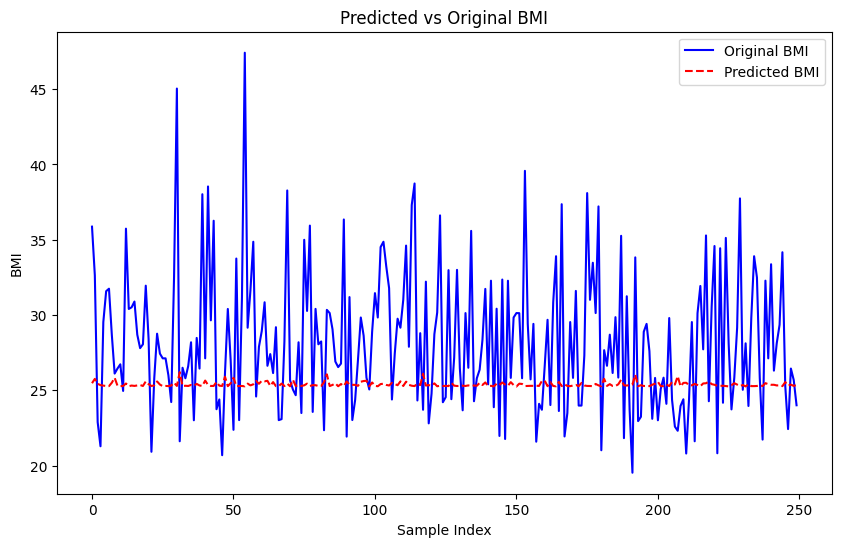


Model Performance on Test Data:
Mean Absolute Error (MAE): 4.11
Mean Squared Error (MSE): 29.53
R-squared (R2 Score): -0.3951

BMI Prediction Accuracy (within ±2.0 BMI units): 34.80%


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the trained model
model = joblib.load('secondmodel.pkl')
print("Model loaded successfully.")

# Function to load and preprocess a batch of images
def load_images(folder, start_index, num_images, img_size=(128, 128)):
    images = []
    valid_indices = []  # Track indices of valid images
    files = sorted(os.listdir(folder))[start_index:start_index + num_images]
    for i, filename in enumerate(files):
        img_path = os.path.join(folder, filename)
        image = cv2.imread(img_path)
        if image is not None:
            image = cv2.resize(image, img_size)
            images.append(image)
            valid_indices.append(start_index + i)
    return np.array(images) / 255.0, valid_indices  # Normalize pixel values to [0, 1]

# Paths to image folders
front_dir = "A:/PRML_project/front/front"
side_dir = "A:/PRML_project/side/side"
labels_file = "A:/PRML_project/person.csv"

# Parameters
START_INDEX = 15000
NUM_IMAGES = 250

# Load images
print("Loading test images...")
X_front_test, valid_indices_front = load_images(front_dir, START_INDEX, NUM_IMAGES)
X_side_test, valid_indices_side = load_images(side_dir, START_INDEX, NUM_IMAGES)

# Ensure the indices are consistent between front and side images
valid_indices = list(set(valid_indices_front) & set(valid_indices_side))
valid_indices.sort()
X_front_test = X_front_test[:len(valid_indices)]
X_side_test = X_side_test[:len(valid_indices)]

print(f"Loaded {len(valid_indices)} valid image pairs.")
print(f"X_front_test shape: {X_front_test.shape}")
print(f"X_side_test shape: {X_side_test.shape}")

# Load and prepare the labels
labels_df = pd.read_csv(labels_file, delimiter=';')

# Correct BMI calculation: weight in pounds, height in inches
labels_df['BMI'] = (labels_df['weight'] / (labels_df['height'] ** 2)) * 703

# Extract the corresponding BMI labels based on valid indices
bmi_labels = labels_df['BMI'].iloc[valid_indices].values

# Remove NaN values (if any) in bmi_labels
valid_indices_no_nan = ~np.isnan(bmi_labels)
X_front_test = X_front_test[valid_indices_no_nan]
X_side_test = X_side_test[valid_indices_no_nan]
bmi_labels = bmi_labels[valid_indices_no_nan]

print(f"Filtered {len(bmi_labels)} valid BMI values after removing NaN.")

# Predict using the model
print("Making predictions...")
predictions = model.predict([X_front_test, X_side_test])

# Extract predicted BMI values and denormalize them
bmi_min, bmi_max = 10, 50  # Assuming BMI is normalized in range [10, 50]
predicted_bmi = predictions[1].flatten()  # Extract BMI predictions
predicted_bmi = predicted_bmi * (bmi_max - bmi_min) + bmi_min  # Denormalize BMI

# Remove any NaN values in predictions
valid_pred_indices = ~np.isnan(predicted_bmi)
predicted_bmi = predicted_bmi[valid_pred_indices]
bmi_labels = bmi_labels[valid_pred_indices]

print(f"Final valid BMI samples: {len(bmi_labels)}")

# Plot graph: Predicted vs. Original BMI
plt.figure(figsize=(10, 6))
plt.plot(bmi_labels, label="Original BMI", color="blue")
plt.plot(predicted_bmi, label="Predicted BMI", color="red", linestyle="--")
plt.title("Predicted vs Original BMI")
plt.xlabel("Sample Index")
plt.ylabel("BMI")
plt.legend()
plt.show()

# Calculate accuracy metrics
mae = mean_absolute_error(bmi_labels, predicted_bmi)
mse = mean_squared_error(bmi_labels, predicted_bmi)
r2 = r2_score(bmi_labels, predicted_bmi)

# Print results
print("\nModel Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

# Calculate accuracy for BMI predictions within a threshold
threshold = 2.0  # Allowable difference for accurate BMI predictions
accurate_count = np.sum(np.abs(predicted_bmi - bmi_labels) <= threshold)
accuracy = (accurate_count / len(bmi_labels)) * 100

print(f"\nBMI Prediction Accuracy (within ±{threshold} BMI units): {accuracy:.2f}%")


In [10]:
import numpy as np
import cv2

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, img_size)  # Resize the image
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Function to calculate BMI with correct units (height in meters and weight in kg)
def calculate_bmi(weight, height_in_inches):
    height_m = height_in_inches * 0.0254  # Convert height to meters
    weight_kg = weight * 0.453592  # Convert weight to kilograms
    bmi = weight_kg / (height_m ** 2)
    return bmi

# Function to classify BMI category
def classify_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return "Correct Weight"
    else:
        return "Overweight"

# Define paths to the test images for two people
image_paths = {
    "p1front": "p3front.jpg",
    "p1side": "p3side.jpg",
    "p2front": "p2front1.jpg",
    "p2side": "p2side1.jpg"
}

# Load and preprocess the images
X_p1front = load_and_preprocess_image(image_paths["p1front"])
X_p1side = load_and_preprocess_image(image_paths["p1side"])
X_p2front = load_and_preprocess_image(image_paths["p2front"])
X_p2side = load_and_preprocess_image(image_paths["p2side"])

# Make predictions on the images for both people
p1_predictions = model.predict([X_p1front, X_p1side])
p2_predictions = model.predict([X_p2front, X_p2side])

# Extract BMI predictions and gender predictions
p1_bmi_prediction = p1_predictions[1][0]  # BMI prediction for person 1
p2_bmi_prediction = p2_predictions[1][0]  # BMI prediction for person 2

# Denormalize BMI predictions to the original range (e.g., 10 to 50)
bmi_min = 10  # Minimum BMI used during training
bmi_max = 50  # Maximum BMI used during training
p1_bmi = p1_bmi_prediction * (bmi_max - bmi_min) + bmi_min
p2_bmi = p2_bmi_prediction * (bmi_max - bmi_min) + bmi_min

# Ensure scalar values for BMI predictions
p1_bmi_value = float(p1_bmi)
p2_bmi_value = float(p2_bmi)

# Actual BMI values for both people
p1_weight = 300  # Example weight in pounds for person 1
p1_height = 67   # Example height in inches for person 1
p2_weight = 155  # Example weight in pounds for person 2
p2_height = 73   # Example height in inches for person 2
p1_actual_bmi = calculate_bmi(p1_weight, p1_height)
p2_actual_bmi = calculate_bmi(p2_weight, p2_height)

# Classify both people based on their BMI predictions and actual BMI
p1_bmi_category = classify_bmi(p1_bmi_value)
p2_bmi_category = classify_bmi(p2_bmi_value)
p1_actual_bmi_category = classify_bmi(p1_actual_bmi)
p2_actual_bmi_category = classify_bmi(p2_actual_bmi)

# Decode gender predictions back to original labels
gender_predictions_p1 = np.argmax(p1_predictions[0], axis=1)  # Gender prediction for person 1
gender_predictions_p2 = np.argmax(p2_predictions[0], axis=1)  # Gender prediction for person 2
decoded_gender_predictions_p1 = encoder.inverse_transform(gender_predictions_p1)
decoded_gender_predictions_p2 = encoder.inverse_transform(gender_predictions_p2)

# Display the results for both people
print(f"Person 1 (Predicted BMI: {p1_bmi_value:.2f}, Actual BMI: {p1_actual_bmi:.2f}): {p1_bmi_category} (Actual: {p1_actual_bmi_category})")
print(f"Person 1 Gender Prediction: {decoded_gender_predictions_p1[0]}")
print(f"Person 2 (Predicted BMI: {p2_bmi_value:.2f}, Actual BMI: {p2_actual_bmi:.2f}): {p2_bmi_category} (Actual: {p2_actual_bmi_category})")
print(f"Person 2 Gender Prediction: {decoded_gender_predictions_p2[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Person 1 (Predicted BMI: 25.62, Actual BMI: 46.99): Overweight (Actual: Overweight)
Person 1 Gender Prediction: Male
Person 2 (Predicted BMI: 25.28, Actual BMI: 20.45): Overweight (Actual: Correct Weight)
Person 2 Gender Prediction: Male


C:\Users\shaik\AppData\Local\Temp\ipykernel_10112\1081999251.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p1_bmi_value = float(p1_bmi)
C:\Users\shaik\AppData\Local\Temp\ipykernel_10112\1081999251.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p2_bmi_value = float(p2_bmi)
